In [1]:
import os
from shutil import copyfile
from __future__ import division, print_function
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import soundfile as sf
import numpy as np
import random
import cv2
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.image as mpimg

# Data and Training Functions

In [2]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        directory: Path to the directory containing images.
        transform: Optional torchvision transforms to apply.
        """
        self.directory = directory
        self.transform = transform
        # List image file paths (supports .png, .jpg, .jpeg)
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        # Open image and convert to grayscale (LeNet expects 1 channel)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform: resize to 28x28 and convert to tensor
            default_transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor()
            ])
            image = default_transform(image)
        
        # Extract the label from the filename using regex (e.g., "0_george_5.png")
        filename = os.path.basename(img_path)
        label_match = re.match(r'(\d+)', filename)
        if label_match:
            label = int(label_match.group(1))
        else:
            raise ValueError(f"Filename {filename} does not start with a numeric label.")
        
        return image, label


In [3]:
def train_and_evaluate(model, train_loader, test_loader, device,
                       num_epochs=30, learning_rate=0.001):
    """
    Trains and evaluates the given model using the provided train and test loaders.
    
    Parameters:
      - model: The neural network model to be trained.
      - train_loader: DataLoader for the training data.
      - test_loader: DataLoader for the testing/validation data.
      - device: The torch device (cpu or cuda) to perform training.
      - num_epochs: Number of training epochs.
      - learning_rate: Learning rate for the optimizer.
      
    Returns:
      - model: The trained model.
      - train_acc_list: List of training accuracies per epoch.
      - test_acc_list: List of testing accuracies per epoch.
    """
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc_list = []
    test_acc_list = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            # Compute training accuracy on-the-fly
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_acc_list.append(train_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        
        # Evaluation on test data
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
        test_accuracy = 100 * correct_test / total_test
        test_acc_list.append(test_accuracy)
        print(f"Test Acc: {test_accuracy:.2f}%")
    
    print("Training complete.")
    return model, train_acc_list, test_acc_list

In [4]:
def plot_accuracies(train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, test_acc, 'ro-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# No Attention Model

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv1: 6 filters, 5x5, 'same' padding (padding=2 for kernel_size=5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # AvgPool1: 2x2, stride=2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Conv2: 16 filters, 5x5, 'valid' padding (padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        # AvgPool2: 2x2, stride=2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # After the convolution and pooling layers:
        # Input image: 28x28 -> after conv1+pool1: 14x14 -> after conv2+pool2: 5x5 (with 16 filters)
        # Flatten: 16 * 5 * 5 = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 10 classes; no softmax needed when using CrossEntropyLoss
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Logits are returned; softmax is applied in the loss function (nn.CrossEntropyLoss)
        return x

In [6]:
batch_size = 16
num_epochs = 30
learning_rate = 0.001

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
# Directories for training and testing
train_dir = "./train/"
test_dir = "./test/"

# Define transforms (resizing to 28x28 and converting to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize from 64x64 to 28x28
    transforms.ToTensor()
])

# Create datasets
train_dataset = CustomDataset(train_dir, transform=transform)
test_dataset  = CustomDataset(test_dir, transform=transform)

# Create data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 2.2715, Train Acc: 14.63%
Test Acc: 19.00%
Epoch 2/30, Loss: 1.5332, Train Acc: 41.59%
Test Acc: 52.33%
Epoch 3/30, Loss: 1.1184, Train Acc: 56.74%
Test Acc: 68.33%
Epoch 4/30, Loss: 0.9420, Train Acc: 63.74%
Test Acc: 64.67%
Epoch 5/30, Loss: 0.8372, Train Acc: 68.67%
Test Acc: 70.67%
Epoch 6/30, Loss: 0.7542, Train Acc: 71.78%
Test Acc: 75.00%
Epoch 7/30, Loss: 0.6571, Train Acc: 76.63%
Test Acc: 78.67%
Epoch 8/30, Loss: 0.5519, Train Acc: 81.70%
Test Acc: 84.33%
Epoch 9/30, Loss: 0.4789, Train Acc: 83.63%
Test Acc: 86.00%
Epoch 10/30, Loss: 0.4144, Train Acc: 86.11%
Test Acc: 89.67%
Epoch 11/30, Loss: 0.3830, Train Acc: 87.15%
Test Acc: 88.00%
Epoch 12/30, Loss: 0.3320, Train Acc: 89.07%
Test Acc: 89.67%
Epoch 13/30, Loss: 0.3114, Train Acc: 90.00%
Test Acc: 92.00%
Epoch 14/30, Loss: 0.2766, Train Acc: 91.11%
Test Acc: 93.33%
Epoch 15/30, Loss: 0.2340, Train Acc: 92.52%
Test Acc: 91.00%
Epoch 16/30, Loss: 0.2134, Train Acc: 93.44%
Test Acc: 91.67%
Epoch 17/30, Loss

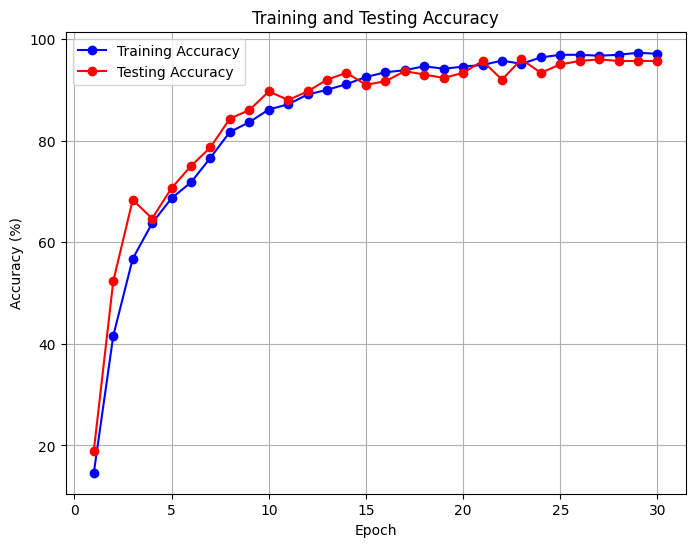

In [21]:
plot_accuracies(train_accuracies, test_accuracies)

# Attention Model

In [22]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=8):
        super().__init__()
        hidden_dim = max(in_channels // reduction, 1)
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_dim, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, in_channels, bias=False)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg = self.avg_pool(x).view(b, c)
        max = self.max_pool(x).view(b, c)
        # Shared MLP on both
        attn = self.mlp(avg) + self.mlp(max)
        attn = self.sigmoid(attn).view(b, c, 1, 1)
        return x * attn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        assert kernel_size in (3, 7), "kernel_size must be 3 or 7"
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Along channel axis, take max & avg
        max_res, _ = torch.max(x, dim=1, keepdim=True)
        avg_res = torch.mean(x, dim=1, keepdim=True)
        cat = torch.cat([max_res, avg_res], dim=1)
        attn = self.sigmoid(self.conv(cat))
        return x * attn

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction)
        self.spatial_att = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x


In [23]:
class AttentionLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # conv + CBAM block 1
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.cbam1 = CBAMBlock(in_channels=6)
        self.pool1 = nn.AvgPool2d(2, 2)

        # conv + CBAM block 2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # default padding=0
        self.cbam2 = CBAMBlock(in_channels=16)
        self.pool2 = nn.AvgPool2d(2, 2)

        # fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # block 1
        x = F.relu(self.conv1(x))
        x = self.cbam1(x)
        x = self.pool1(x)

        # block 2
        x = F.relu(self.conv2(x))
        x = self.cbam2(x)
        x = self.pool2(x)

        # classifier
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
model = AttentionLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 2.3053, Train Acc: 9.04%
Test Acc: 10.00%
Epoch 2/30, Loss: 2.0358, Train Acc: 21.96%
Test Acc: 34.67%
Epoch 3/30, Loss: 1.4556, Train Acc: 42.37%
Test Acc: 57.33%
Epoch 4/30, Loss: 1.1644, Train Acc: 53.15%
Test Acc: 63.33%
Epoch 5/30, Loss: 1.0235, Train Acc: 59.89%
Test Acc: 68.00%
Epoch 6/30, Loss: 0.8972, Train Acc: 67.07%
Test Acc: 68.33%
Epoch 7/30, Loss: 0.8218, Train Acc: 69.52%
Test Acc: 75.00%
Epoch 8/30, Loss: 0.7448, Train Acc: 73.07%
Test Acc: 76.00%
Epoch 9/30, Loss: 0.6744, Train Acc: 75.85%
Test Acc: 79.67%
Epoch 10/30, Loss: 0.5905, Train Acc: 79.22%
Test Acc: 83.33%
Epoch 11/30, Loss: 0.5493, Train Acc: 80.30%
Test Acc: 81.33%
Epoch 12/30, Loss: 0.5112, Train Acc: 82.89%
Test Acc: 84.33%
Epoch 13/30, Loss: 0.4498, Train Acc: 85.00%
Test Acc: 84.33%
Epoch 14/30, Loss: 0.4187, Train Acc: 85.56%
Test Acc: 83.67%
Epoch 15/30, Loss: 0.3856, Train Acc: 86.93%
Test Acc: 86.00%
Epoch 16/30, Loss: 0.3626, Train Acc: 87.41%
Test Acc: 87.00%
Epoch 17/30, Loss:

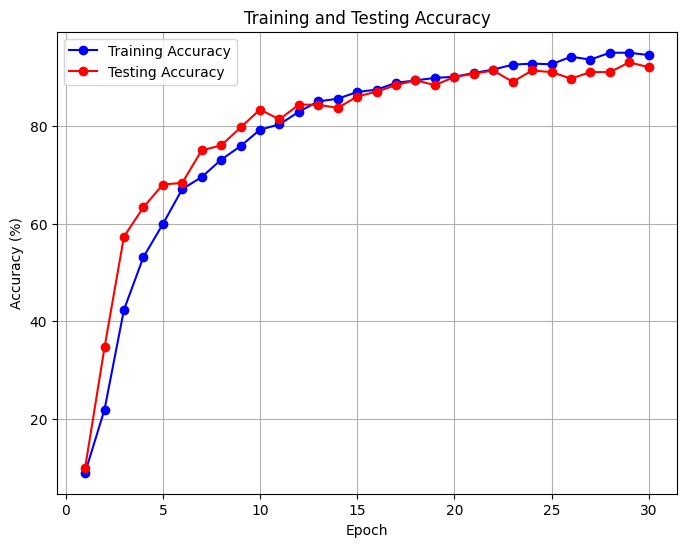

In [26]:
plot_accuracies(train_accuracies, test_accuracies)

In [30]:
num_epochs = 40
model = AttentionLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
trained_model, train_accuracies, test_accuracies = train_and_evaluate(model, train_loader, test_loader, device, num_epochs)

Epoch 1/40, Loss: 2.3038, Train Acc: 10.22%
Test Acc: 10.00%
Epoch 2/40, Loss: 1.9226, Train Acc: 25.26%
Test Acc: 34.67%
Epoch 3/40, Loss: 1.4380, Train Acc: 43.37%
Test Acc: 56.67%
Epoch 4/40, Loss: 1.0945, Train Acc: 58.52%
Test Acc: 67.33%
Epoch 5/40, Loss: 0.9538, Train Acc: 63.78%
Test Acc: 68.33%
Epoch 6/40, Loss: 0.8284, Train Acc: 69.11%
Test Acc: 68.33%
Epoch 7/40, Loss: 0.7308, Train Acc: 74.15%
Test Acc: 79.33%
Epoch 8/40, Loss: 0.6596, Train Acc: 75.56%
Test Acc: 79.67%
Epoch 9/40, Loss: 0.5728, Train Acc: 79.67%
Test Acc: 80.33%
Epoch 10/40, Loss: 0.5284, Train Acc: 81.59%
Test Acc: 82.00%
Epoch 11/40, Loss: 0.4765, Train Acc: 84.04%
Test Acc: 85.33%
Epoch 12/40, Loss: 0.4517, Train Acc: 84.33%
Test Acc: 84.67%
Epoch 13/40, Loss: 0.3913, Train Acc: 86.56%
Test Acc: 88.00%
Epoch 14/40, Loss: 0.3749, Train Acc: 87.93%
Test Acc: 88.33%
Epoch 15/40, Loss: 0.3394, Train Acc: 89.22%
Test Acc: 86.33%
Epoch 16/40, Loss: 0.3223, Train Acc: 89.67%
Test Acc: 85.67%
Epoch 17/40, Loss

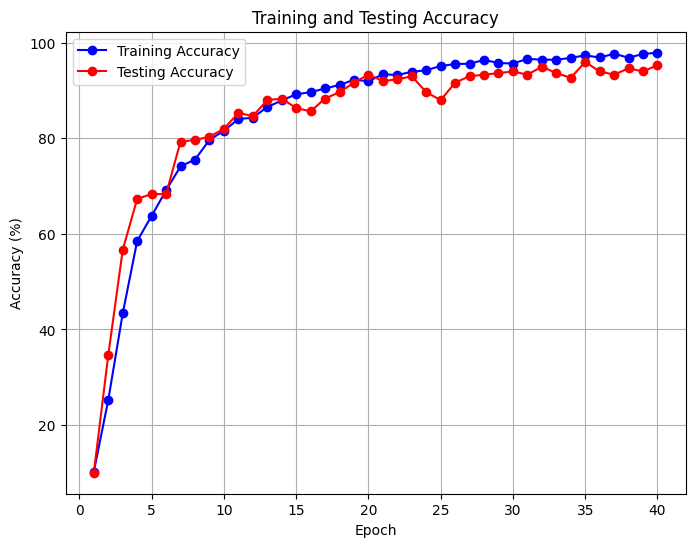

In [32]:
plot_accuracies(train_accuracies, test_accuracies)